[Reference](https://medium.com/analytics-vidhya/probability-calibration-essentials-with-code-6c446db74265)

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Create classifiation dataset with 2 classes, 100000 samples, 20 features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=7, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,random_state=42)

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1, solver='lbfgs')
nb = GaussianNB()
svc = SVC(max_iter=10000,probability =True)

preds_logreg = lr.fit(X_train,y_train).predict_proba(X_test)[:,1]
preds_naive_bayes = nb.fit(X_train,y_train).predict_proba(X_test)[:,1]
preds_svc = svc.fit(X_train,y_train).predict(X_test)

Text(0.5, 1.0, 'Probability Density Plot for 3 Classifiers')

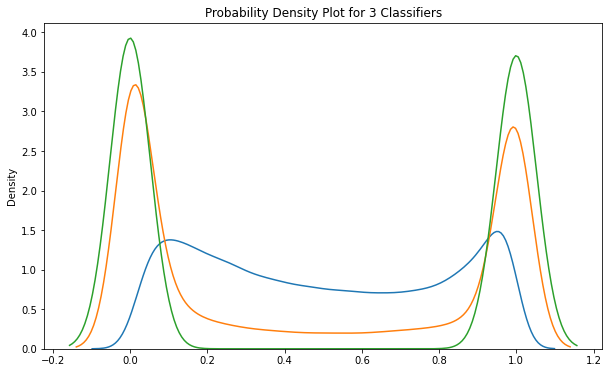

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(preds_logreg,label="Logreg")
sns.kdeplot(preds_naive_bayes,label="NB")
sns.kdeplot(preds_svc,label="SVC")
plt.title("Probability Density Plot for 3 Classifiers")

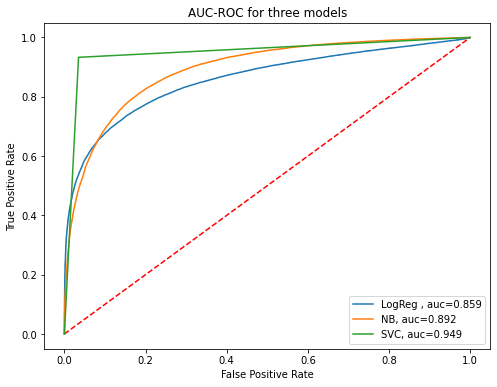

In [4]:
import matplotlib.pyplot as plt
from sklearn import metrics

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

pred = preds_logreg
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="LogReg , auc="+str(round(auc,3)))

pred = preds_naive_bayes
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="NB, auc="+str(round(auc,3)))

pred = preds_svc
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="SVC, auc="+str(round(auc,3)))

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC-ROC for three models")
plt.legend(loc=0)
plt.show()

# Model calibration Viz via Reliability plots

LogReg:
	Brier: 0.149
	Precision: 0.805
	Recall: 0.763
	F1: 0.783

	AUC:0.859

Naive Bayes:
	Brier: 0.153
	Precision: 0.845
	Recall: 0.761
	F1: 0.801

	AUC:0.892

SVC:
	Brier: 0.039
	Precision: 0.964
	Recall: 0.933
	F1: 0.948

	AUC:0.986



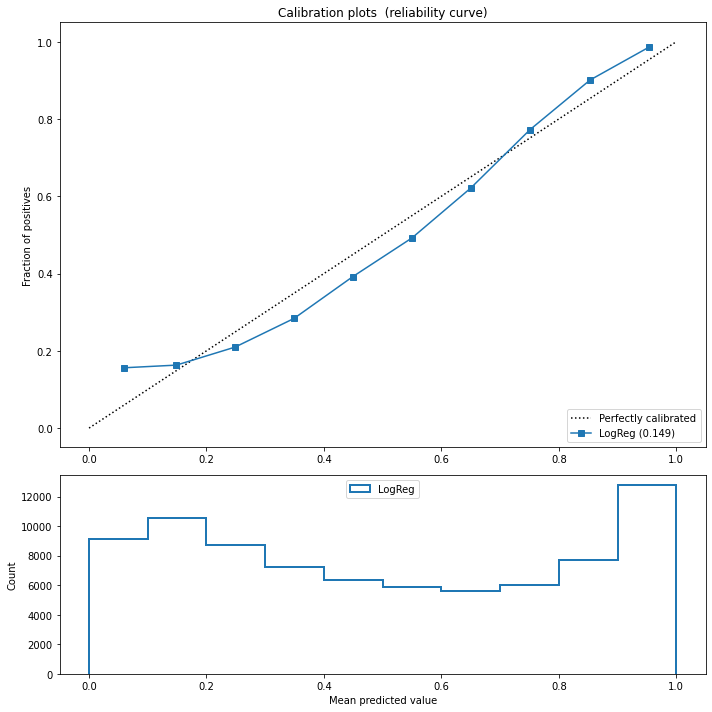

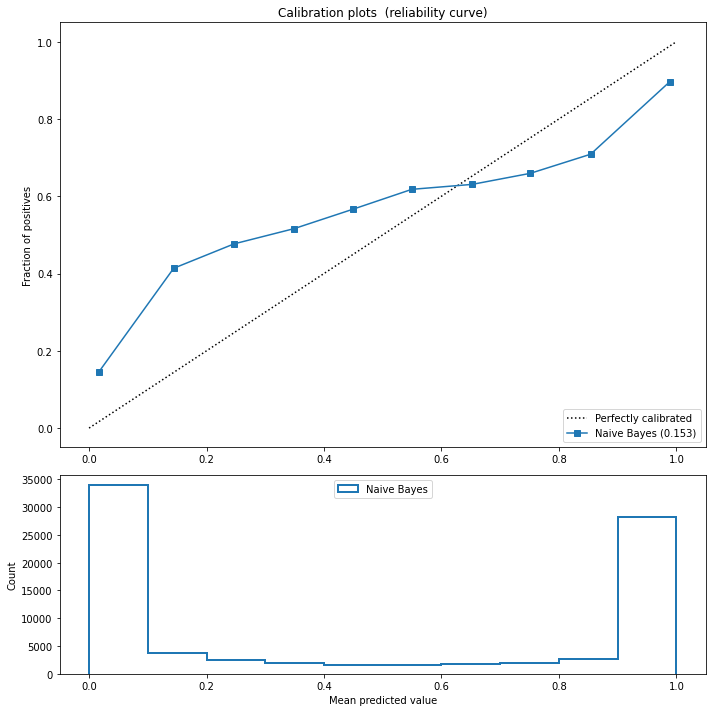

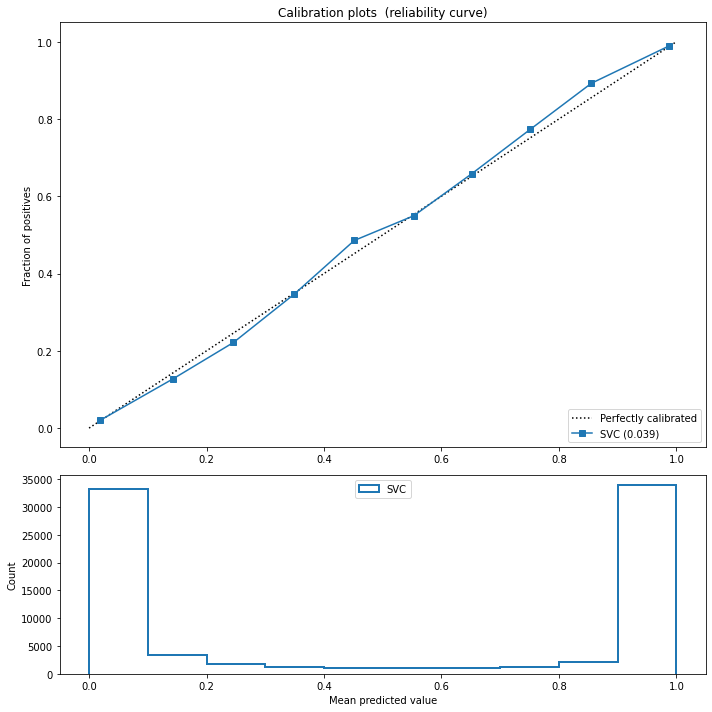

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(clf, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
    print("\tAUC:{}\n".format(round(metrics.roc_auc_score(y_test, prob_pos),3)))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(LogisticRegression(C=1, solver='lbfgs'), "LogReg", 1)

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 2)

# Plot calibration curve for Linear SVC
plot_calibration_curve(SVC(max_iter=10000,probability =True), "SVC", 3)

plt.show()

LogReg:
	Brier: 0.149
	Precision: 0.805
	Recall: 0.763
	F1: 0.783

LogReg + Isotonic:
	Brier: 0.147
	Precision: 0.844
	Recall: 0.714
	F1: 0.774

Naive Bayes:
	Brier: 0.153
	Precision: 0.845
	Recall: 0.761
	F1: 0.801

Naive Bayes + Isotonic:
	Brier: 0.132
	Precision: 0.814
	Recall: 0.814
	F1: 0.814

SVC:
	Brier: 0.039
	Precision: 0.964
	Recall: 0.933
	F1: 0.948

SVC + Isotonic:
	Brier: 0.042
	Precision: 0.956
	Recall: 0.934
	F1: 0.945



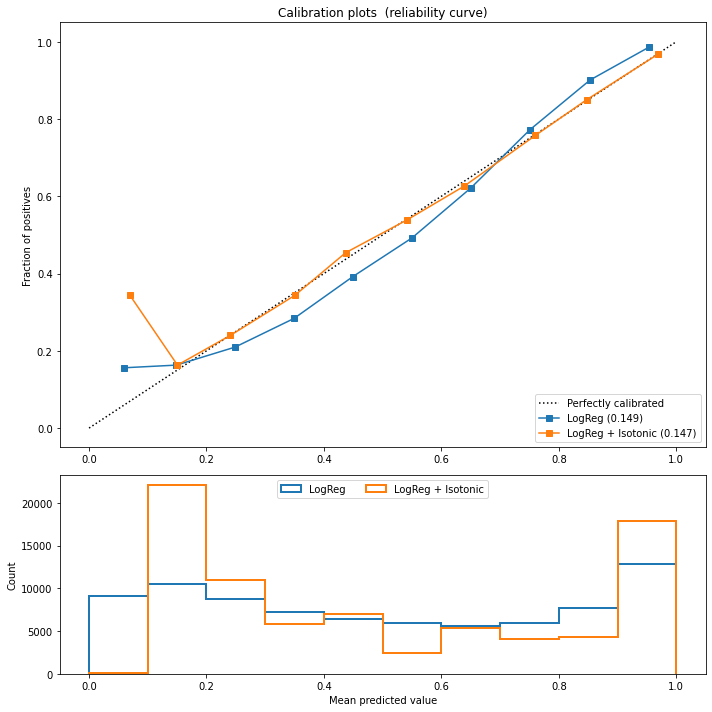

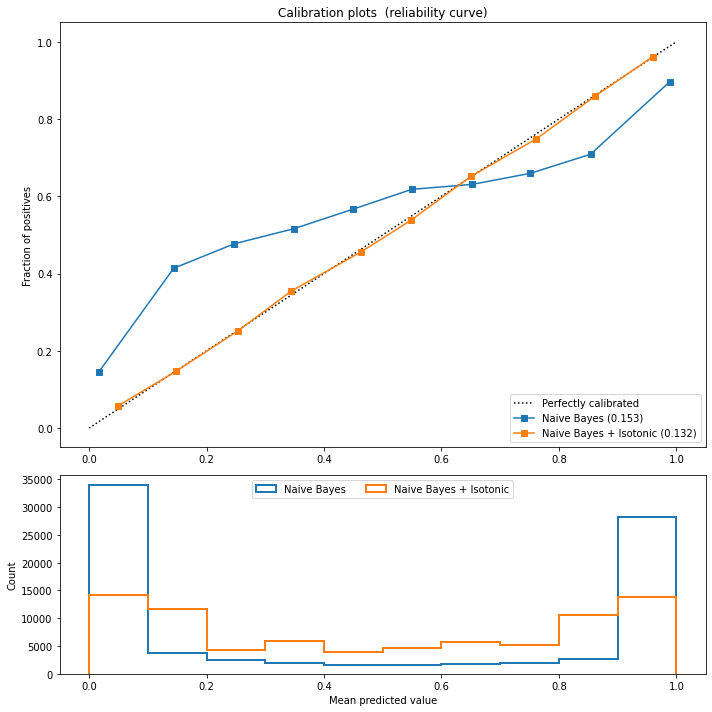

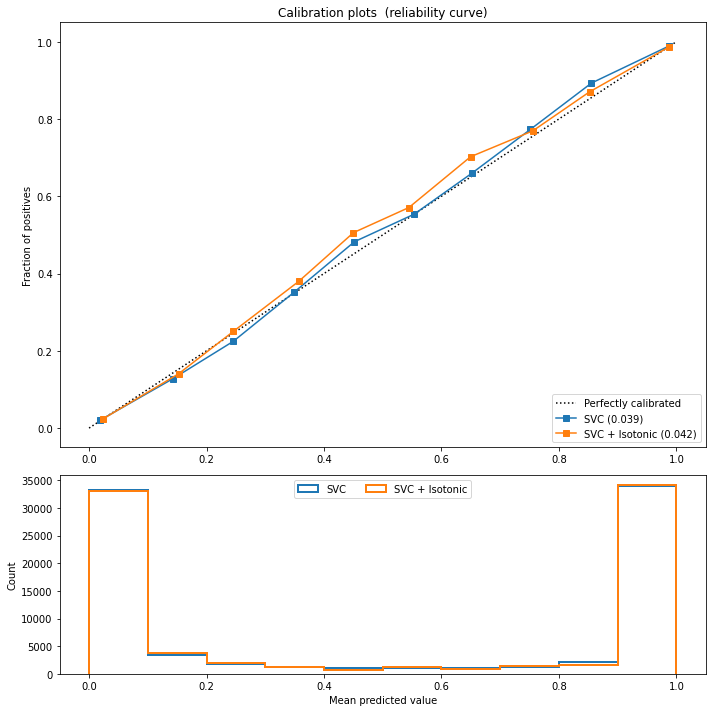

In [6]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    #sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    #lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(LogisticRegression(C=1, solver='lbfgs'), "LogReg", 1)

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 2)

# Plot calibration curve for Linear SVC
plot_calibration_curve(SVC(max_iter=10000,probability =True), "SVC", 3)

plt.show()